学習がうまくいったのかどうかを確かめる

1. 予測誤差（全ての時刻における二乗誤差の平均）がinnovationの分散より小さけれな良い

$\sqrt{\mathbb{E}[(\hat X_t-X_t)^2]}$  と  $\sigma^{\ast}$の大小

2. というより普通にinnovationを予測できていればいいのでは？

3. 一応正規性とか独立性も確認して、できていなかったとしてもどこができていないのかを見るべき。でないと正則化の係数を変えられない

In [1]:
%matplotlib inline
import argparse
import os
path = os.getcwd()
path=path[:path.find('timeseries-WGAN')+15]
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path+"/")
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

In [2]:
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models

まずはチェック用のデータを取得

$p^{\ast}=7$, $\phi^{\ast}=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1]$, $\mu^{\ast}=0$, $\sigma^{\ast}=2$, $_{test}T=1000$<br>
に従うARモデルから生成されるデータ

In [3]:
phi_ast=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1]
p_ast=len(phi_ast)
mu_ast=0
sigma_ast=2

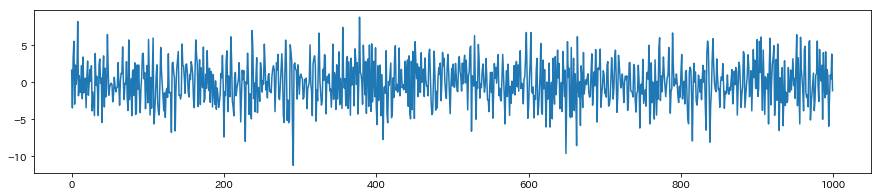

In [4]:
# まずはある時系列を作る（訓練データと生成モデルは同じ）
seed=2**32 - 1
testT=1000
testData = tsModel.SARIMA(a=phi_ast, N=testT, random_seed=seed, mu=mu_ast, sigma=sigma_ast)
plt.figure(figsize=(15,3))
plt.plot(testData, label="観測時系列")

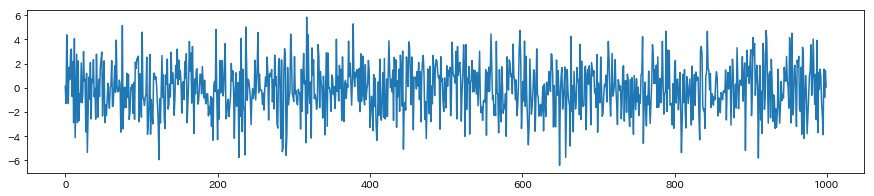

In [5]:
eps = tsModel.SARIMA(a=phi_ast, N=testT, random_seed=seed, mu=mu_ast, sigma=sigma_ast, return_innovation=True)
plt.figure(figsize=(15,3))
plt.plot(eps, label="観測時系列")

## $p=7$の場合

In [6]:
hat_p=7

## まずは予測誤差がそれなりに小さくなっているかどうかを確かめる。

まずは推定モデルを読み込む

In [7]:
! ls parameters/p7/

discriminator_epoch1000_batchSize64_GP1_Corr1_DataSeed0.pth
discriminator_epoch1_batchSize64_GP1_Corr0.pth
discriminator_epoch1_batchSize64_GP1_Corr0_DataSeed0.pth
discriminator_epoch2000_batchSize64_GP1_Corr1_DataSeed0.pth
discriminator_epoch3000_batchSize64_GP1_Corr1_DataSeed0.pth
discriminator_epoch50_batchSize64_GP1_Corr1_DataSeed0.pth
generator_epoch1000_batchSize64_GP1_Corr1_DataSeed0.pth
generator_epoch1_batchSize64_GP1_Corr0.pth
generator_epoch1_batchSize64_GP1_Corr0_DataSeed0.pth
generator_epoch2000_batchSize64_GP1_Corr1_DataSeed0.pth
generator_epoch3000_batchSize64_GP1_Corr1_DataSeed0.pth
generator_epoch50_batchSize64_GP1_Corr1_DataSeed0.pth
predictor_epoch1000_batchSize64_GP1_Corr1_DataSeed0.pth
predictor_epoch1_batchSize64_GP1_Corr0.pth
predictor_epoch1_batchSize64_GP1_Corr0_DataSeed0.pth
predictor_epoch2000_batchSize64_GP1_Corr1_DataSeed0.pth
predictor_epoch3000_batchSize64_GP1_Corr1_DataSeed0.pth
predictor_epoch50_batchSize64_GP1_Corr1_DataSeed0.pth


In [8]:
parameter_path = "parameters/p{0}/generator_epoch50_batchSize64_GP1_Corr1_DataSeed0.pth".format(hat_p)
print(parameter_path)
generator = models.LinearGenerator(p = hat_p, input_dim=1, is_bias=False)
generator.load_state_dict(torch.load(parameter_path))

parameters/p7/generator_epoch50_batchSize64_GP1_Corr1_DataSeed0.pth


<All keys matched successfully>

In [9]:
parameter_path = "parameters/p{0}/discriminator_epoch50_batchSize64_GP1_Corr1_DataSeed0.pth".format(hat_p)
print(parameter_path)
discriminator = models.Discriminator(q=0, discriminator_hidden_unit=64)
discriminator.load_state_dict(torch.load(parameter_path))

parameters/p7/discriminator_epoch50_batchSize64_GP1_Corr1_DataSeed0.pth


<All keys matched successfully>

In [25]:
parameter_path = "parameters/p{0}/predictor_epoch50_batchSize64_GP1_Corr1_DataSeed0.pth".format(hat_p)
print(parameter_path)
predictor = models.LinearPredictNet(p=hat_p, input_dim=1, is_bias=True)
predictor.load_state_dict(torch.load(parameter_path))

parameters/p7/predictor_epoch50_batchSize64_GP1_Corr1_DataSeed0.pth


<All keys matched successfully>

In [11]:
predictor.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.0745,  1.1553, -0.2952,  0.2937, -0.1039,  0.2403, -0.3499,  0.0896]])),
             ('fc1.bias', tensor([0.0925]))])

### そしたら$F_{\phi}$のパラメータを確認

In [26]:
hat_mu = float(predictor.state_dict()['fc1.bias'])
print(hat_mu)
hat_sigma = float(predictor.state_dict()['fc1.weight'][0][0])
print(hat_sigma)
hat_phi = [round(float(predictor.state_dict()['fc1.weight'][0][i]),3) for i in range(1, hat_p+1)]
print(hat_phi)

0.006501203402876854
1.2150604724884033
[-0.256, -0.685, 0.707, 0.711, 0.401, -0.038, -0.365]


In [19]:
hat_mu = float(predictor.state_dict()['fc1.bias'])
print(hat_mu)
hat_sigma = float(predictor.state_dict()['fc1.weight'][0][0])
print(hat_sigma)
hat_phi = [-round(float(predictor.state_dict()['fc1.weight'][0][hat_p-i+1]),3) for i in range(1, hat_p+1)]
print(hat_phi)

4.5097120164427906e-05
1.1770012378692627
[0.385, -0.243, -0.272, -0.766, -0.581, 0.689, 0.117]


In [13]:
print(mu_ast)
print(sigma_ast)
print(phi_ast)

0
2
[0.3, -0.4, 0.2, -0.5, 0.6, -0.1, 0.1]


全然違うじゃぁーん！

### 予測誤差をみます

使うのは$F_{\phi}(X_{t-1},\cdots, X_{t-p}, \varepsilon_t=0)$

いやでもパラーメータが全然違ったら絶対に誤差が小さい分けないんだよなぁ

### 

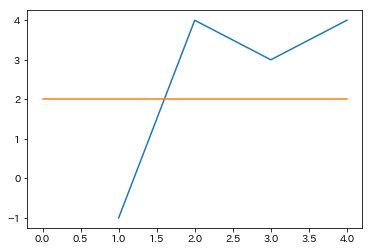

In [24]:
a=[None, -1, 4, 3,4]
b = [2,2,2,2,2]
plt.plot(a)
plt.plot(b)